# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Заказчик.** Сервис по продаже автомобилей с пробегом «Не бит, не крашен»

**Цель Заказчика.** Разработка приложения в котором можно быстро узнать рыночную стоимость своего автомобиля.

**Цель исследования.** Построить модель для определения стоимости автомобиля. Характеричтики модели:
- высокое качество предсказания;
- высокая скорость предсказания;
- короткое время обучения

**Задачи:**

- Загрузить и подготовить данные.
- Обучить разные модели. Для каждой попробовать различные гиперпараметры.
- Проанализировать скорость работы и качество моделей.

**Входные данные от Заказчика.** Файл в формате .csv с данными о продаваемых машинах

**Ожидаемый результат.** Построена модель для определения стоимости автомобиля, со значением метрики RMSE менее 2500 и лучшим временем обучения.

## Подготовка данных

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Цеоевой признак**

- `Price` — цена (евро)

In [16]:
# Импотрт библиотек
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from time import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score # кросс-вылидация
from sklearn.model_selection import GridSearchCV # кросс-вылидация
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

In [17]:
# Прочитаем файл
try:
    df = pd.read_csv('/datasets/autos.csv')
    
except FileNotFoundError:
    df = pd.read_csv('C:\\Users\\Aser\\Первый ноутбук\\Projects\\data\\autos.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [18]:
# Изучим состав данных методом info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Таблица содержит 354 369 строк и 16 столбцов. Типы данных во всех интерессуемых столбцах корректны (столбцы с датами для дальнейшей рабты интереса не представляют). Имеется пропуски данных в пяти столбцах.

In [19]:
# Проверим наличие дубликатов и пропусков
print('Коичество явных дубликатов', df.duplicated().sum())
print('Количество пропусков:')
print(df.isna().sum())

Коичество явных дубликатов 4
Количество пропусков:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [20]:
# Изучим вероятность наличия неявных дубликатов
column_list = df.columns
for i in column_list:
    print(i)
    print(df[i].sort_values().unique())

DateCrawled
['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
Price
[    0     1     2 ... 19998 19999 20000]
VehicleType
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
RegistrationYear
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 

In [21]:
# Определим состав признака Price
df['Price'].value_counts().sort_index()

0        10772
1         1189
2           12
3            8
4            1
         ...  
19995       10
19997        1
19998        6
19999      278
20000      268
Name: Price, Length: 3731, dtype: int64

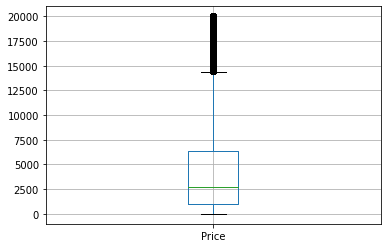

In [22]:
# Изобразим выбросы на графике
df.loc[:, ['Price']].boxplot()
plt.show()

In [23]:
# Определим верхний уровень выбросов
price_mean = df['Price'].mean()
price_std = np.std(list(df['Price']), ddof=1)
sig_max = price_mean + 3 * price_std
print('Верхний уровень выброса - ', sig_max)

Верхний уровень выброса -  17959.132317533244


In [24]:
# Определим нижний уровень выбросов
print('Нижний уровень выброса - ', df['Price'].quantile(0.05))

Нижний уровень выброса -  200.0


In [25]:
price_list = df['Price'].value_counts().sort_index()
print('Количество нижних выбросов', price_list[price_list.index < 200].sum())
print('Количество верхних выбросов', price_list[price_list.index > 18000].sum())

Количество нижних выбросов 17462
Количество верхних выбросов 4831


Судя по графику и значению квантиля 5% – выбросом является цены со значением менее 200 (17462 повторения).

Используя правило трех сигм определена верхняя граница выброса – 18 000 (4831 повторение)

Таким образом, необходимо удалить строки со значением цены менее 200 и более 18000

In [26]:
# Определим состав признака Power
df['Power'].value_counts().sort_index()

0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 712, dtype: int64

In [27]:
power_list = df['Power'].value_counts().sort_index()
print('Количество данных верхнего выброса', power_list[power_list.index > 1000].sum())

Количество данных верхнего выброса 302


In [28]:
# Изучим корреляционные зависимости
display(df.corr())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [29]:
# Исследуем файл методом describe()
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Выводы**

Представленный дата-сет содержит 354 369 строк и 16 столбцов. Типы данных во всех столбцах корректны. Имеется 4 явных дубликата и пропуски данных в пяти столбцах – от 19705 до 37490 ячеек. 

В целевом признаке `Price` есть 17 462 значений с ценой менее 200 и 4 831 зачений более 18000. Эти значеня являются выбросами и при построении модели на эти данные нельзя будет опираться. Их надо удалить.

Присутствуют некорректные данные в признаке `RegistrationYear` – например 1000 или 9999 годы. Строки с некорректными данными надо будет удалить, поскольку они не позволяют определить реальный возраст машины.

Также некорректные данные есть в признаке `Power` – нулевые или слишком высокие значения. Не смотря на то, что нулевых данных очень много (40 225), и они составляют значимую часть дата-сета, их удалим. Кроме того, удалим все ст роки со значением менее 50 лс. Слишком большие данные надо удалить. Поскольку, серийные автомобили с мощностью выше 1000  лс встречаются кране редко и, вероятнее всего, не продаются через объявления, то строки со значением мощности выше 1000 можно удалить


***Необходимо произвести следующие изменения:***

- Изменить названия столбцов и привести их к змеиному регистру»
- Удалить явные дубликаты
- Удалить строки с ценой ниже 200 и выше 18 000
- Удалить строки с мощностью ниже 50 лс и выше 1000 лс
- Удалить строки со значением года регистрации ранее 1970 и позднее 2020
- В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` пропуски заменить на `unknow`
- Стобцы `DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationMonth`, `PostalCode` удалить из признаков
- Выполнить прямое кодирование для столбцов `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`

Нормализация данных не требуется

In [30]:
# Изменим названия столбцов
df = df.rename(columns={
    'DateCrawled': 'date_crawled', 
    'Price': 'price', 
    'VehicleType': 'vehicle_type', 
    'RegistrationYear': 'registration_year', 
    'Gearbox': 'gearbox',
    'Power': 'power', 
    'Model': 'model', 
    'Kilometer': 'kilometer', 
    'RegistrationMonth': 'registration_month', 
    'FuelType': 'fuel_type', 
    'Brand': 'brand',
    'NotRepaired': 'not_repaired', 
    'DateCreated': 'date_created', 
    'NumberOfPictures': 'number_of_pictures', 
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen'})

# Удалимлим яврые дубли
df = df.drop_duplicates().reset_index(drop=True)
print('Количество явных дублей - ', df.duplicated().sum())

# Удалим строки с "выбросами" цен и строки со значением года регистрации ранее 1910 и позднее 2020
df = df.loc[
    (df['price']>200) & 
    (df['price']<18000) & 
    (df['power']>50) & 
    (df['power']<1000) & 
    (df['registration_year']>=1970) & 
    (df['registration_year']<=2020)
].copy()

# Пропуски заменим на unknow
df['vehicle_type'] = df['vehicle_type'].fillna('unknow')
df['gearbox'] = df['gearbox'].fillna('unknow')
df['model'] = df['model'].fillna('unknow')
df['fuel_type'] = df['fuel_type'].fillna('unknow')
df['not_repaired'] = df['not_repaired'].fillna('unknow')

# Удалим столбцы DateCrawled, DateCreated, LastSeen из признаков
#df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

df.head()

Количество явных дублей -  0


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39


In [31]:
# Удалим столбцы DateCrawled, DateCreated, LastSeen из признаков
df.drop(['date_crawled', 'date_created', 'last_seen', 'registration_month', 'postal_code'], axis=1, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,number_of_pictures
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknow,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,0


In [32]:
df.describe()

,price,registration_year,power,kilometer,number_of_pictures
count,286927.000000,286927.000000,286927.000000,286927.000000,286927.0
mean,4741.657373,2003.534683,122.256811,129258.225960,0.0
std,4240.951599,6.443068,52.383057,35871.893736,0.0
min,202.000000,1970.000000,51.000000,5000.000000,0.0
25%,1450.000000,1999.000000,82.000000,125000.000000,0.0
50%,3250.000000,2004.000000,115.000000,150000.000000,0.0
75%,6900.000000,2008.000000,150.000000,150000.000000,0.0
max,17999.000000,2019.000000,999.000000,150000.000000,0.0


In [33]:
# Разделим таблицу на признаки и целевые результаты
features = df.drop(['price'], axis=1)
target = df['price']

# Выполним прямое кодирование
features = pd.get_dummies(features, drop_first=True)

display(features.head())

,registration_year,power,kilometer,number_of_pictures,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknow,not_repaired_yes
2,2004,163,125000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,90000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1995,102,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2004,109,150000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение моделей

In [34]:
state = RandomState(12345)

In [35]:
# Разделим данные на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train.shape}')
print(f'Обучающая выборка целевого признака - {target_train.shape}')
print(f'Тестовая выборка признаков - {features_test.shape}')
print(f'Тестовая выборка целевого признака - {target_test.shape}')

Обучающая выборка признаков - (215195, 310)
Обучающая выборка целевого признака - (215195,)
Тестовая выборка признаков - (71732, 310)
Тестовая выборка целевого признака - (71732,)


In [36]:
# Создадим списки для записи результатов тестов
model = []
model_name = []
rmse_result = []
time_fit_result = []
time_predict_result = []

In [37]:
# Обучим модель методом линейной регрессии
model_name.append('line_regr_light')

t1 = time()
model_regr_light = LinearRegression()
model_regr_light.fit(features_train, target_train)
t2 = time()
answer_regr_light = model_regr_light.predict(features_test)
t3 = time()
rmse_model_regr_light = (mean_squared_error(target_test, answer_regr_light))**.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(model_regr_light)
rmse_result.append(round(rmse_model_regr_light, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_model_regr_light:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

Точность модели по RMSE: 2353.0919
Время обучение модели: 18.2291
Скорость предсказания: 0.2969


In [38]:
# Обучим модель методом линейной регрессии с использованем кросс-валидация (3 частей)
model_name.append('line_regr_cross_valid')
line_regr_cross_valid_list = []
all_line = len(target_train)
sample_size = int(all_line//3.1)

t1 = time()
for i in range(0, all_line, sample_size):
    if i+sample_size >= all_line:
        break
    else:
        valid_indexes = list(range(i, i+sample_size)) 
        train_indexes = list(range(0, i)) + list(range(i+sample_size, all_line))

        # Создадим выборки методом кросс-валидация и обучим модель
        features_train_short = features_train.loc[features_train.index[train_indexes]]
        target_train_short = target_train.loc[target_train.index[train_indexes]]
        features_valid_short = features_train.loc[features_train.index[valid_indexes]]
        target_valid_short = target_train.loc[target_train.index[valid_indexes]]
    
        model_line_regr_cross_valid = LinearRegression()
        model_line_regr_cross_valid.fit(features_train_short, target_train_short)
        predict_test = model_line_regr_cross_valid.predict(features_valid_short)

        # Проверим качество модели
        rmse_test_short = mean_squared_error(target_valid_short, predict_test)
        line_regr_cross_valid_list.append(rmse_test_short)
    
# Рассчитаем среднее качество модели
fin_line_regr_cross_valid_list = (sum(line_regr_cross_valid_list) / len(line_regr_cross_valid_list))**0.5
print(f'На модели логистической регрессии средний уровень RMSE = {fin_line_regr_cross_valid_list:.4f}')

t2 = time()
answer_line_regr_cross_valid = model_line_regr_cross_valid.predict(features_test)
t3 = time()
rmse_model_line_regr_cross_valid = (mean_squared_error(target_test, answer_line_regr_cross_valid))**0.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(model_line_regr_cross_valid)
rmse_result.append(round(rmse_model_line_regr_cross_valid, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_model_line_regr_cross_valid:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

На модели логистической регрессии средний уровень RMSE = 2367.5796
Точность модели по RMSE: 2353.7421
Время обучение модели: 39.5308
Скорость предсказания: 0.3104


In [39]:
# Подберем лучшие параметры Решающего дерева методом GridSearchCV
model_name.append('tree_regr')

t1 = time()
clf = DecisionTreeRegressor(random_state=state)
parametrs = {'max_depth': range(5, 11)}

model_tree_regr = GridSearchCV(clf, parametrs, cv=3)
model_tree_regr.fit(features_train, target_train)
best_depth_tree_regr = model_tree_regr.best_params_.get('max_depth')
print(f'Лучший параметр глубины - {best_depth_tree_regr}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeRegressor(max_depth=best_depth_tree_regr, random_state=state)
model_tree.fit(features_train, target_train)

t2 = time()
answer_model_tree = model_tree.predict(features_test)
t3 = time()
rmse_model_tree = (mean_squared_error(target_test, answer_model_tree))**0.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(model_tree)
rmse_result.append(round(rmse_model_tree, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_model_tree:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

Лучший параметр глубины - 10
Точность модели по RMSE: 1866.2008
Время обучение модели: 48.7419
Скорость предсказания: 0.1271


In [40]:
# Улучшим модель Решающего дарава меняя число деревьев
model_name.append('forest_regr')

best_result_forest = 100000
best_est_forest = 0
best_model_forest = 0
best_rmse_model_forest = 0

t1 = time()
for est in range(5, 16, 5):
    model_forest = RandomForestRegressor(random_state=state,
                                   n_estimators=est, 
                                   max_depth=best_depth_tree_regr)
    model_forest.fit(features_train, target_train)
    predict_model_forest = model_forest.predict(features_test)
    test_model_forest = (mean_squared_error(target_test, predict_model_forest))**0.5
    
    if best_result_forest > test_model_forest:
        best_result_forest = test_model_forest
        best_est_forest = est
        best_model_forest = model_forest
        best_rmse_model_forest = test_model_forest
print(f'Лучший параметр числа деревьев - {best_est_forest}')

t2 = time()
answer_model_forest = best_model_forest.predict(features_test)
t3 = time()
rmse_model_forest = (mean_squared_error(target_test, answer_model_forest))**0.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(best_model_forest)
rmse_result.append(round(rmse_model_forest, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_model_forest:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

Лучший параметр числа деревьев - 15
Точность модели по RMSE: 1786.5068
Время обучение модели: 78.1602
Скорость предсказания: 0.2102


In [41]:
# Проверка "наивным" алгоритмом
model_name.append('dummy_regr')

t1 = time()
naive_model = DummyRegressor(strategy="mean")
naive_model.fit(features_train, target_train)
t2 = time()
answer_naive = naive_model.predict (features_test)
t3 = time()
rmse_naive_model = (mean_squared_error(target_test, answer_naive))**0.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(naive_model)
rmse_result.append(round(rmse_naive_model, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_naive_model:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

Точность модели по RMSE: 4245.3055
Время обучение модели: 0.0008
Скорость предсказания: 0.0006


In [42]:
# Создадим модель с испльзоаванием Фреймворка LightGBM
model_name.append('lgb_regr')

t1 = time()
lgb_model = lgb.LGBMModel(objective="regression", n_estimators=10)
lgb_model.fit(features_train, target_train, eval_set=[(features_test, target_test),], eval_metric="rmse")

t2 = time()
answerr_lgb_model = lgb_model.predict(features_test)
t3 = time()
rmse_lgb_model = (mean_squared_error(target_test, answerr_lgb_model))**0.5

time_fit = t2 - t1
time_predict = t3 - t2

model.append(lgb_model)
rmse_result.append(round(rmse_lgb_model, 4))
time_fit_result.append(round(time_fit, 4))
time_predict_result.append(round(time_predict, 4))
print(f"Точность модели по RMSE: {rmse_lgb_model:.4f}")
print(f"Время обучение модели: {time_fit:.4f}")
print(f"Скорость предсказания: {time_predict:.4f}")

[1]	valid_0's rmse: 3947.09	valid_0's l2: 1.55795e+07
[2]	valid_0's rmse: 3688.33	valid_0's l2: 1.36038e+07
[3]	valid_0's rmse: 3456.96	valid_0's l2: 1.19506e+07
[4]	valid_0's rmse: 3251.77	valid_0's l2: 1.0574e+07
[5]	valid_0's rmse: 3077.19	valid_0's l2: 9.4691e+06
[6]	valid_0's rmse: 2922.05	valid_0's l2: 8.53835e+06
[7]	valid_0's rmse: 2788.33	valid_0's l2: 7.77476e+06
[8]	valid_0's rmse: 2670.99	valid_0's l2: 7.13418e+06
[9]	valid_0's rmse: 2566.39	valid_0's l2: 6.58634e+06
[10]	valid_0's rmse: 2477.3	valid_0's l2: 6.13704e+06
Точность модели по RMSE: 2477.3040
Время обучение модели: 3.7334
Скорость предсказания: 0.3912


## Анализ моделей

In [43]:
# Выведем полученные данные в таблицу
result_model = pd.DataFrame({
    'indicanor': model_name,
    'rmse_result': rmse_result,
    'time_fit': time_fit_result,
    'time_predict': time_predict_result,
    'model': model
})

display(result_model)

,indicanor,rmse_result,time_fit,time_predict,model
0,line_regr_light,2353.0919,18.2291,0.2969,LinearRegression()
1,line_regr_cross_valid,2353.7421,39.5308,0.3104,LinearRegression()
2,tree_regr,1866.2008,48.7419,0.1271,"DecisionTreeRegressor(max_depth=10,\n ..."
3,forest_regr,1786.5068,78.1602,0.2102,"(DecisionTreeRegressor(max_depth=10, max_featu..."
4,dummy_regr,4245.3055,0.0008,0.0006,DummyRegressor()
5,lgb_regr,2477.3040,3.7334,0.3912,"LGBMModel(n_estimators=10, objective='regressi..."


**Выводы**

По результату обучения нескольких моделей наиболее точный результат дает метод `Случайный лес` с количеством деревьев **15** и глубиной каждого дерева – **10**. Показатель `RMSE` данной модели составляет **1786**. 

Однако, `Случайный лес` - это одна из самых медленно обучаемых моделей. Учитывая требование заказчика помимо высокой точности предсказания, обеспечить короткое время на обучение модели, представляется целесообразным обратиться к модели `Решающего дерева` с максимальной глубиной **10**.

`Решающее дерево` обеспечивает точность `RMSE` на уровне **1866**, что является вторым по точности результатом. При этом, скорость обучения данной модели одна из самых высоких (выше только `линейной регрессии`), а скорость предсказания – самая высокая.

**Таким образом**, рекомендовано к использованию модель `Решающего дерева` с максимальной глубиной **10**
